# Context

The use of drones in increasingly diverse fields (logistics, surveillance, infrastructure
inspection, or even rescue operations) comes with growing challenges of reliability and
safety.
 Drone failures can lead to loss of equipment, service interruptions, or risks to
people.
 It is therefore essential to prevent breakdowns through preventive maintenanceand
early fault detectionapproaches, in order to intervene before an incident occurs or to
quickly identify its cause.

# Objective

Based on the provided sensor data (in full or in part), the objective is to develop an
analysis and anomaly detection model capable of, depending on the chosen approach:</br>

 • Detecting the presence of a fault in the drone’s operation;</br>
 • Identifying the probable originof the fault;</br>
 • Assessing the severityof the detected fault to guide maintenance actions.</br>

 In short, the goal is to implement a predictive maintenanceapproach to improve the
availability, safety, and lifespan of drones.

# Loading the data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import re
import os

In [3]:
def load_drone_data(path):
    data = loadmat(path)
    return data["commander_data"], data["QDrone_data"], data["stabilizer_data"]

In [4]:
def extract_commander_data(commander):
    df = pd.DataFrame({
        "time": commander[0, :],
        "meas_x": commander[21, :],
        "meas_y": commander[22, :],
        "meas_z": commander[23, :],
        "meas_yaw": commander[24, :],
        "ref_x": commander[25, :],
        "ref_y": commander[26, :],
        "ref_z": commander[27, :],
        "ref_yaw": commander[28, :],
        "ref_thrust": commander[33, :],
        "ref_roll": commander[34, :],
        "ref_pitch": commander[35, :],
        "ref_yaw_rate": commander[36, :]
    })
    return df

In [5]:
def extract_qdrone_data(qdrone):
    df = pd.DataFrame({
        "time": qdrone[0, :],
        # IMU 1 orientation
        "imu1_roll": qdrone[1, :],
        "imu1_pitch": qdrone[2, :],
        "imu1_yaw": qdrone[3, :],
        "imu1_roll_rate": qdrone[4, :],
        "imu1_pitch_rate": qdrone[5, :],
        "imu1_yaw_rate": qdrone[6, :],
        "imu1_roll_acc": qdrone[7, :],
        "imu1_pitch_acc": qdrone[8, :],
        "imu1_yaw_acc": qdrone[9, :],
        # IMU 2 orientation
        "imu2_roll": qdrone[10, :],
        "imu2_pitch": qdrone[11, :],
        "imu2_yaw": qdrone[12, :],
        "imu2_roll_rate": qdrone[13, :],
        "imu2_pitch_rate": qdrone[14, :],
        "imu2_yaw_rate": qdrone[15, :],
        "imu2_roll_acc": qdrone[16, :],
        "imu2_pitch_acc": qdrone[17, :],
        "imu2_yaw_acc": qdrone[18, :],
        # Other sensors
        "battery_level": qdrone[23, :],
        "gyro1_roll_rate": qdrone[26, :],
        "gyro1_pitch_rate": qdrone[27, :],
        "gyro1_yaw_rate": qdrone[28, :],
        "accel1_x": qdrone[29, :],
        "accel1_y": qdrone[30, :],
        "accel1_z": qdrone[31, :],
        "gyro2_roll_rate": qdrone[32, :],
        "gyro2_pitch_rate": qdrone[33, :],
        "gyro2_yaw_rate": qdrone[34, :],
        "accel2_x": qdrone[35, :],
        "accel2_y": qdrone[36, :],
        "accel2_z": qdrone[37, :],
        "height_range": qdrone[45, :],
        # Motor and ESC commands
        "front_left_motor_cmd": qdrone[46, :],
        "front_left_esc_cmd": qdrone[47, :],
        "front_right_motor_cmd": qdrone[48, :],
        "front_right_esc_cmd": qdrone[49, :],
        "back_left_motor_cmd": qdrone[50, :],
        "back_left_esc_cmd": qdrone[51, :],
        "back_right_motor_cmd": qdrone[52, :],
        "back_right_esc_cmd": qdrone[53, :]
    })
    return df

In [6]:
def extract_stabilizer_data(stabilizer):
    df = pd.DataFrame({
        "time": stabilizer[0, :],
        "flight_mode": stabilizer[6, :]
    })
    return df

In [7]:
def parse_filename(fname):
    match = re.match(r"F(\d+)_SV(\d+)_SP(\d+)_t(\d+)", fname)
    if match:
        F, SV, SP, t = map(int, match.groups())
        return F, SV, SP, t
    return None, None, None, None

In [8]:
def process_file(file_path):
    fname = os.path.basename(file_path)
    F, SV, SP, t = parse_filename(fname)

    commander, qdrone, stabilizer = load_drone_data(file_path)

    df_commander = extract_commander_data(commander)
    df_qdrone = extract_qdrone_data(qdrone)
    df_stabilizer = extract_stabilizer_data(stabilizer)

    # Merge all on time (approx)
    df = df_commander.merge(df_qdrone, on="time", how="outer")
    df = df.merge(df_stabilizer, on="time", how="outer")

    # Add metadata columns
    df["fault_type"] = F
    df["severity"] = SV
    df["speed_level"] = SP
    df["trajectory"] = t
    return df

In [9]:
if __name__ == "__main__":
    data_dir = "/content/drive/MyDrive/Hackathon_UAV/mat"
    files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.mat')]

    all_df = []
    for f in files:
        df = process_file(f)
        all_df.append(df)

    combined = pd.concat(all_df, ignore_index=True)
    combined.to_csv("DronePropA_Full_Extraction.csv", index=False)
    print("Extraction complete \u2192 Saved as DronePropA_Full_Extraction.csv")

Extraction complete → Saved as DronePropA_Full_Extraction.csv


In [10]:
data = pd.read_csv('DronePropA_Full_Extraction.csv')

# Data Exploration and Preparation

In [11]:
data.head(10)

,time,meas_x,meas_y,meas_z,meas_yaw,ref_x,ref_y,ref_z,ref_yaw,ref_thrust,...,front_right_esc_cmd,back_left_motor_cmd,back_left_esc_cmd,back_right_motor_cmd,back_right_esc_cmd,flight_mode,fault_type,severity,speed_level,trajectory
0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.000000,...,0.0,0.006768,0.048881,0.006768,0.0,0.0,0,0,1,4
1,0.001,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.000429,...,0.0,0.006752,0.048881,0.006752,0.0,0.0,0,0,1,4
2,0.002,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.001325,...,0.0,0.006760,0.048881,0.006760,0.0,0.0,0,0,1,4
3,0.003,-0.041595,-0.006993,0.006476,-0.037553,0.000000e+00,0.000000e+00,0.0,0.0,-0.202036,...,0.0,0.006764,0.048881,0.006764,0.0,0.0,0,0,1,4
4,0.004,-0.041595,-0.006993,0.006476,-0.037553,-1.000000e-07,-1.000000e-07,0.0,0.0,-0.201453,...,0.0,0.006724,0.048881,0.006724,0.0,0.0,0,0,1,4
5,0.005,-0.041595,-0.006993,0.006476,-0.037553,-4.000000e-07,-4.000000e-07,0.0,0.0,-0.202082,...,0.0,0.006760,0.048881,0.006760,0.0,0.0,0,0,1,4
6,0.006,-0.041595,-0.006993,0.006476,-0.037553,-9.000000e-07,-9.000000e-07,0.0,0.0,-0.205011,...,0.0,0.006776,0.048881,0.006776,0.0,0.0,0,0,1,4
7,0.007,-0.041595,-0.006993,0.006476,-0.037553,-1.600000e-06,-1.600000e-06,0.0,0.0,-0.209393,...,0.0,0.006744,0.048881,0.006744,0.0,0.0,0,0,1,4
8,0.008,-0.041590,-0.006987,0.006475,-0.037538,-2.500000e-06,-2.500000e-06,0.0,0.0,-0.214650,...,0.0,0.006748,0.048881,0.006748,0.0,0.0,0,0,1,4
9,0.009,-0.041590,-0.006987,0.006475,-0.037538,-3.600000e-06,-3.600000e-06,0.0,0.0,-0.220731,...,0.0,0.006756,0.048881,0.006756,0.0,0.0,0,0,1,4


In [12]:
data.isna().sum()

,0
time,0
meas_x,0
meas_y,0
meas_z,0
meas_yaw,0
ref_x,0
ref_y,0
ref_z,0
ref_yaw,0
ref_thrust,0


In [13]:
columns_to_drop = [
    "front_left_esc_cmd",
    "front_right_esc_cmd",
    "back_left_esc_cmd",
    "back_right_esc_cmd"
]

data.drop(columns=columns_to_drop, inplace=True)
print(f"Dropped columns: {columns_to_drop}")


Dropped columns: ['front_left_esc_cmd', 'front_right_esc_cmd', 'back_left_esc_cmd', 'back_right_esc_cmd']


In [14]:
data.shape[0]

826365

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 826365 entries, 0 to 826364
Data columns (total 54 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   time                   826365 non-null  float64
 1   meas_x                 826365 non-null  float64
 2   meas_y                 826365 non-null  float64
 3   meas_z                 826365 non-null  float64
 4   meas_yaw               826365 non-null  float64
 5   ref_x                  826365 non-null  float64
 6   ref_y                  826365 non-null  float64
 7   ref_z                  826365 non-null  float64
 8   ref_yaw                826365 non-null  float64
 9   ref_thrust             826365 non-null  float64
 10  ref_roll               826365 non-null  float64
 11  ref_pitch              826365 non-null  float64
 12  ref_yaw_rate           826365 non-null  float64
 13  imu1_roll              826365 non-null  float64
 14  imu1_pitch             826365 non-nu

In [16]:
data.describe()

,time,meas_x,meas_y,meas_z,meas_yaw,ref_x,ref_y,ref_z,ref_yaw,ref_thrust,...,height_range,front_left_motor_cmd,front_right_motor_cmd,back_left_motor_cmd,back_right_motor_cmd,flight_mode,fault_type,severity,speed_level,trajectory
count,826365.000000,826365.000000,826365.000000,826365.000000,826365.000000,826365.000000,826365.000000,826365.000000,826365.000000,826365.000000,...,826365.000000,826365.000000,826365.000000,826365.000000,826365.000000,826365.0,826365.000000,826365.000000,826365.000000,826365.000000
mean,38.860193,-0.064977,-0.051548,0.548961,0.108704,-0.072372,-0.048069,0.536716,0.115759,-1.610385,...,0.627010,0.501102,0.478201,0.478238,0.490314,0.0,1.145011,1.091414,1.659400,3.392903
std,23.710995,0.412830,0.414620,0.293361,0.350311,0.428778,0.430997,0.300857,0.350349,0.983896,...,0.309751,0.156722,0.151164,0.149670,0.155712,0.0,1.171543,1.168621,0.473911,1.400773
min,0.000000,-1.030327,-1.063515,0.000000,-0.238743,-1.000000,-1.000000,0.000000,-0.057604,-14.099266,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,1.000000
25%,18.781000,-0.032873,-0.034247,0.247600,-0.011057,-0.025762,-0.017233,0.200000,0.000000,-1.780477,...,0.302327,0.519359,0.501649,0.499912,0.510268,0.0,0.000000,0.000000,1.000000,2.000000
50%,37.562000,0.003832,-0.009379,0.746303,-0.005439,0.000000,0.000000,0.750000,0.000000,-1.537045,...,0.830365,0.551081,0.523775,0.522585,0.539478,0.0,1.000000,1.000000,2.000000,3.000000
75%,57.335000,0.019449,0.009675,0.754663,0.002427,0.000000,0.000000,0.750000,0.000000,-1.312018,...,0.847148,0.572835,0.545123,0.544308,0.561642,0.0,2.000000,2.000000,2.000000,5.000000
max,96.240000,1.066909,1.042978,0.854833,1.597657,1.000000,1.000000,0.800000,1.570796,16.446693,...,1.059006,0.810684,0.781168,0.729844,0.738488,0.0,3.000000,3.000000,2.000000,5.000000


# Feature Engineering

**Objective:** Transform raw drone signals into structured, interpretable metrics for analysis and fault
 detection.

## Position and Orientation Errors</br>



*   Compute deviation between measured and reference positions (X, Y, Z).
*   Compute yaw
 misalignment using wrapped angular difference.





In [17]:
data["error_x"] = data["meas_x"] - data["ref_x"]
data["error_y"] = data["meas_y"] - data["ref_y"]
data["error_z"] = data["meas_z"] - data["ref_z"]
data["pos_error_norm"] = np.sqrt(data["error_x"]**2 + data["error_y"]**2 + data["error_z"]**2)

# Safe yaw difference (handles wrap-around)
data["yaw_error"] = np.arctan2(np.sin(data["meas_yaw"] - data["ref_yaw"]),
                               np.cos(data["meas_yaw"] - data["ref_yaw"]))

## Velocity and Acceleration



*   Derive drone velocity and acceleration by differentiating position over time.
*   Compute overall
 speed magnitude to capture motion intensity.



In [18]:
data["dt"] = data["time"].diff().fillna(method="bfill")

# Velocity
data["vel_x"] = data["meas_x"].diff() / data["dt"]
data["vel_y"] = data["meas_y"].diff() / data["dt"]
data["vel_z"] = data["meas_z"].diff() / data["dt"]
data["speed"] = np.sqrt(data["vel_x"]**2 + data["vel_y"]**2 + data["vel_z"]**2)

# Acceleration
data["acc_x"] = data["vel_x"].diff() / data["dt"]
data["acc_y"] = data["vel_y"].diff() / data["dt"]
data["acc_z"] = data["vel_z"].diff() / data["dt"]
data["acc_mag"] = np.sqrt(data["acc_x"]**2 + data["acc_y"]**2 + data["acc_z"]**2)

/tmp/ipython-input-3524246221.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data["dt"] = data["time"].diff().fillna(method="bfill")


## Stability & Vibration Features


*   Use IMU signals (angular rates, accelerations) to quantify vibration levels.
*   High-frequency
 variations indicate propeller imbalance or structural fault.



In [19]:
data["ang_vel_imu1"] = np.sqrt(
    data["imu1_roll_rate"]**2 + data["imu1_pitch_rate"]**2 + data["imu1_yaw_rate"]**2
)
data["ang_acc_imu1"] = np.sqrt(
    data["imu1_roll_acc"]**2 + data["imu1_pitch_acc"]**2 + data["imu1_yaw_acc"]**2
)
data["lin_acc_imu1"] = np.sqrt(
    data["accel1_x"]**2 + data["accel1_y"]**2 + data["accel1_z"]**2
)

## Actuator (Motor) Symmetry Features


*   Analyze motor command signals to detect imbalance between motors.
*   Compute mean, standard
 deviation, and asymmetry index across all four motors.



In [20]:
motors = [
    "front_left_motor_cmd", "front_right_motor_cmd",
    "back_left_motor_cmd", "back_right_motor_cmd"
]

data["motor_mean"] = data[motors].mean(axis=1)
data["motor_std"] = data[motors].std(axis=1)
data["motor_asym"] = data["motor_std"] / (data["motor_mean"] + 1e-6)

## Energy / Power Proxy


*   Measure fluctuations in reference thrust as an indicator of control effort.
*    Smoother thrust profile implies stable dynamics.



In [21]:
data["thrust_fluctuation"] = data["ref_thrust"].diff().abs()
data["thrust_smoothness"] = data["thrust_fluctuation"].rolling(10).mean()

## Statistical & Frequency Features


*   Aggregate per-flight metrics (mean, std, max, min) across each feature group.
*    Useful for ML model input representation.



In [22]:
feature_cols = [
    "pos_error_norm", "yaw_error", "speed", "acc_mag",
    "ang_vel_imu1", "ang_acc_imu1", "lin_acc_imu1",
    "motor_asym", "motor_mean", "thrust_smoothness"
]

summary = data.groupby(["fault_type", "severity", "trajectory"]).agg({
    col: ["mean", "std", "max", "min"] for col in feature_cols
})
summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
summary = summary.reset_index()
summary.to_csv("DronePropA_Feature_Summary.csv", index=False)


## Feature Correlation Check


*   Compute correlation matrix across engineered features.
*   Identify redundant or highly correlated
 metrics before model training.



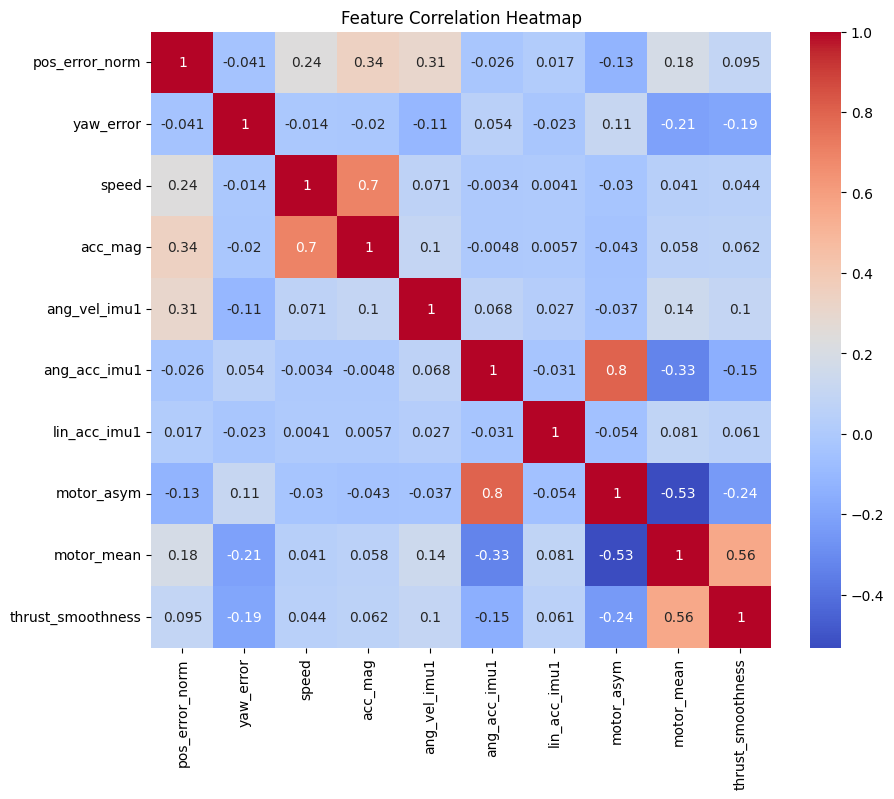

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = data[feature_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", annot=True)
plt.title("Feature Correlation Heatmap")
plt.show()

<Axes: xlabel='fault_type', ylabel='pos_error_norm'>

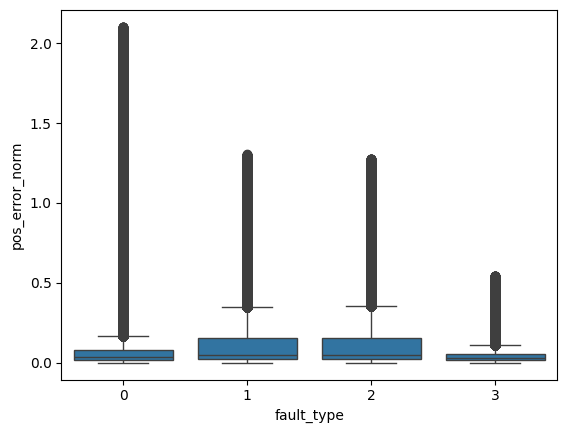

In [24]:
import seaborn as sns
sns.boxplot(data=data, x="fault_type", y="pos_error_norm")

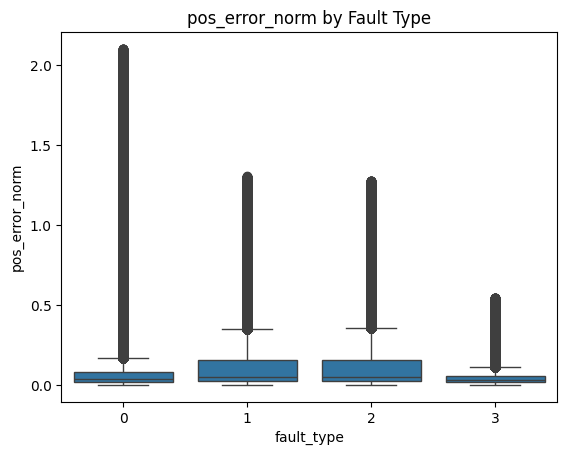

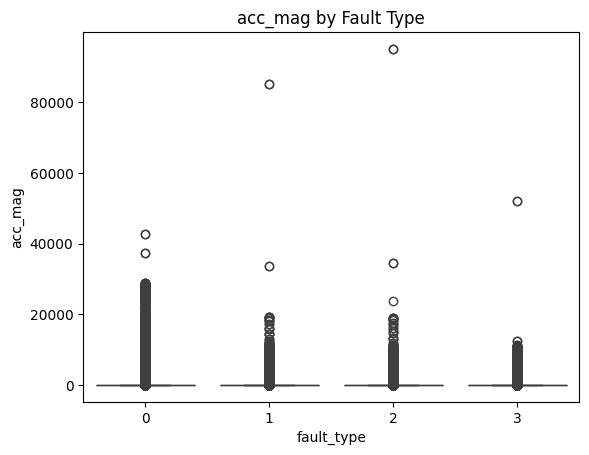

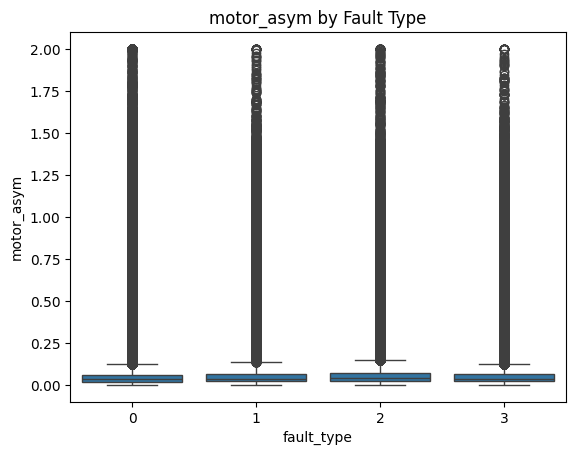

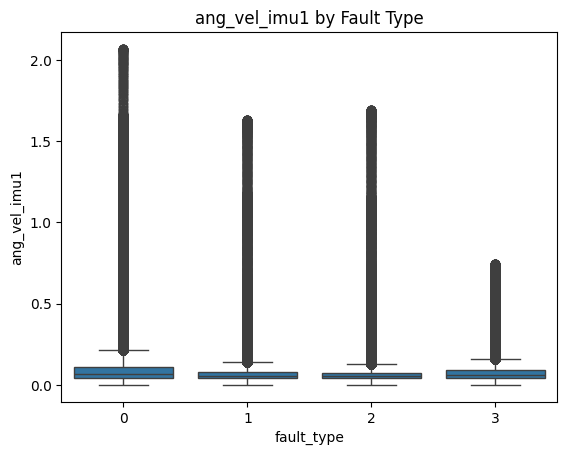

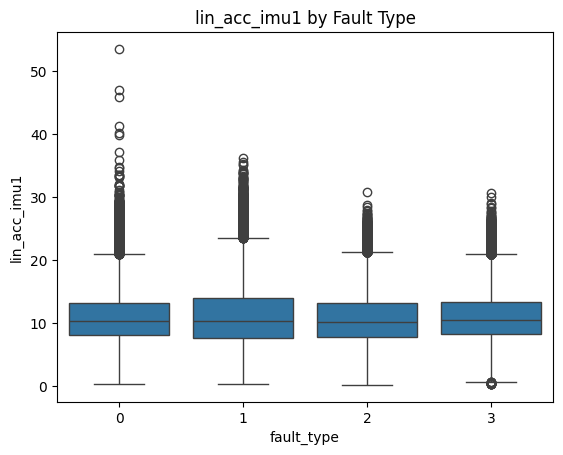

In [25]:
features = ["pos_error_norm", "acc_mag", "motor_asym", "ang_vel_imu1", "lin_acc_imu1"]
for feat in features:
    sns.boxplot(data=data, x="fault_type", y=feat)
    plt.title(f"{feat} by Fault Type")
    plt.show()


<Axes: xlabel='pos_error_norm', ylabel='Density'>

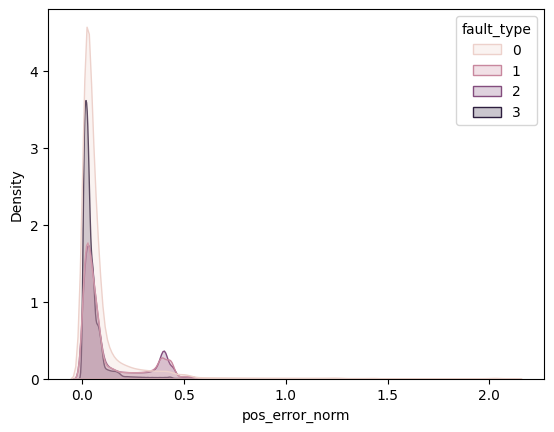

In [26]:
sns.kdeplot(data=data, x="pos_error_norm", hue="fault_type", fill=True)

## Engineered Data
 Store final engineered features as DronePropA_FeatureEngineered.csv for modeling and
 analysis.

In [27]:
data.to_csv("DronePropA_FeatureEngineered.csv", index=False)
print("Feature engineering complete → Saved as DronePropA_FeatureEngineered.csv")

Feature engineering complete → Saved as DronePropA_FeatureEngineered.csv


In [28]:
import pandas as pd
import numpy as np

In [29]:
df = pd.read_csv('/content/DronePropA_FeatureEngineered.csv')

# Normalization

In [30]:
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [31]:
df["fault_label"] = (df["fault_type"] > 0).astype(int)

In [32]:
num_features = [
    "pos_error_norm", "yaw_error", "speed", "acc_mag",
    "ang_vel_imu1", "ang_acc_imu1", "lin_acc_imu1",
    "motor_asym", "motor_mean", "ref_thrust", "thrust_smoothness"
]

In [33]:
X = df[num_features].copy()
y = df["fault_label"]
groups = df["trajectory"]

In [34]:
std_features = ["pos_error_norm", "speed", "acc_mag", "ang_vel_imu1", "ang_acc_imu1", "lin_acc_imu1"]
mm_features  = ["motor_asym", "motor_mean", "ref_thrust", "thrust_smoothness"]

In [35]:
scaler_std = StandardScaler()
scaler_mm = MinMaxScaler()

X[std_features] = scaler_std.fit_transform(X[std_features])
X[mm_features]  = scaler_mm.fit_transform(X[mm_features])

In [36]:
X["yaw_error"] = X["yaw_error"] / np.pi

Group-based train/test split

In [37]:
splitter = GroupShuffleSplit(test_size=0.3, n_splits=1, random_state=42)
for train_idx, test_idx in splitter.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

Train Random Forest model

In [38]:
from sklearn.model_selection import train_test_split

X = X.fillna(0) # Ensure all NaNs are filled before splitting
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [39]:
print(df["fault_type"].value_counts())
print(df["fault_label"].value_counts())


fault_type
0    355596
3    160274
1    155615
2    154880
Name: count, dtype: int64
fault_label
1    470769
0    355596
Name: count, dtype: int64


In [40]:
print(X.isna().sum())


pos_error_norm       0
yaw_error            0
speed                0
acc_mag              0
ang_vel_imu1         0
ang_acc_imu1         0
lin_acc_imu1         0
motor_asym           0
motor_mean           0
ref_thrust           0
thrust_smoothness    0
dtype: int64


In [41]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))


              precision    recall  f1-score   support

           0       0.54      0.18      0.27    106679
           1       0.59      0.89      0.71    141231

    accuracy                           0.58    247910
   macro avg       0.57      0.53      0.49    247910
weighted avg       0.57      0.58      0.52    247910



Classification Report:
               precision    recall  f1-score   support

           0     0.9737    0.9577    0.9656    106679
           1     0.9685    0.9805    0.9744    141231

    accuracy                         0.9707    247910
   macro avg     0.9711    0.9691    0.9700    247910
weighted avg     0.9707    0.9707    0.9706    247910



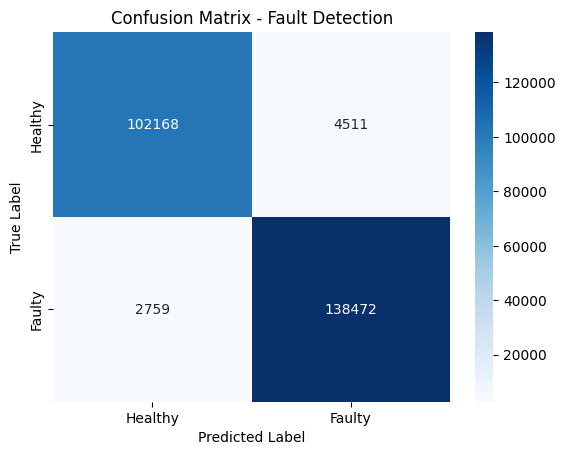

In [42]:
# Train the classifier
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    random_state=42,
    class_weight="balanced"
)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Faulty"], yticklabels=["Healthy", "Faulty"])
plt.title("Confusion Matrix - Fault Detection")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
